### All of the imports

In [4]:
import re
import nltk

import pandas as pd
import numpy as np

from os import sep, makedirs
from os.path import dirname, realpath, join, isdir, exists

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import cross_val_predict, cross_val_score, StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import log_loss, accuracy_score, f1_score
import scikitplot.plotters as skplt

from nltk.corpus import stopwords

import gensim
import itertools
import emoji

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Loading the Data

In [5]:
uppath = lambda _path, n: sep.join(_path.split(sep)[:-n]) # moves the path 'n' levels up the directory

__file__ = dirname(realpath('__file__'))
data_parent_directory = uppath(__file__, 2)
data_directory = join(data_parent_directory, 'Data')
real_or_not_directory = join(data_directory, 'real-or-not')

The data is in the form of a zip file, so we extract CVSs from it.

In [6]:
from zipfile import ZipFile

def extract_real_or_not_data(zipfile_directory, real_or_not_directory):
    
    if not isdir(real_or_not_directory):
        makedirs(real_or_not_directory)
    
    real_or_not_path = join(zipfile_directory, 'real-or-not.zip')
    with ZipFile(real_or_not_path, 'r') as zip:
            zip.extractall(path=real_or_not_directory)

In [7]:
def load_real_or_not_data(real_or_not_directory):
    train_csv = join(real_or_not_directory, "train.csv")
    test_csv = join(real_or_not_directory, "test.csv")
    return pd.read_csv(train_csv), pd.read_csv(test_csv)

In [8]:
extract_real_or_not_data(data_directory, real_or_not_directory)

train, test = load_real_or_not_data(real_or_not_directory)

In [9]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
train.shape

(7613, 5)

### Some initial analysis

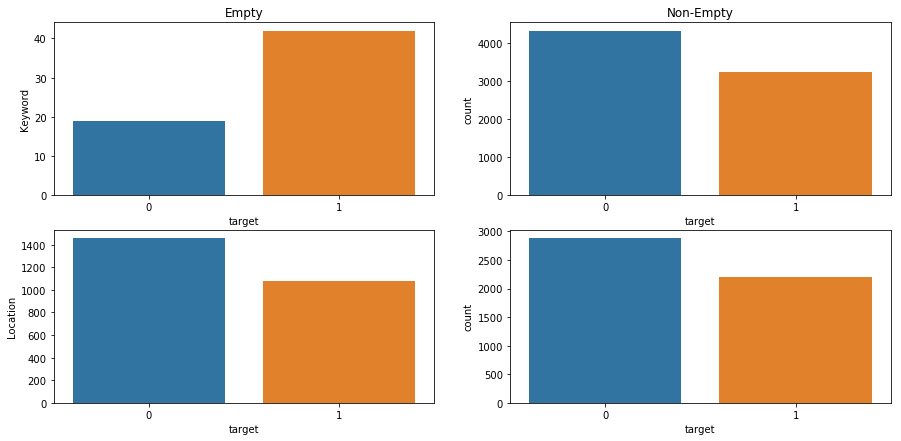

In [11]:
figure, axes = plt.subplots(2,2, figsize=(15,7))
sns.countplot(x='target', data=train[train['keyword'].isna()], ax=axes[0][0])
sns.countplot(x='target', data=train[train['keyword'].notnull()], ax=axes[0][1]) 
sns.countplot(x='target', data=train[train['location'].isna()], ax=axes[1][0]) 
sns.countplot(x='target', data=train[train['location'].notnull()], ax=axes[1][1]) 

axes[0][0].set_ylabel('Keyword'); axes[0][0].set_title('Empty')
axes[1][0].set_ylabel('Location'); axes[0][1].set_title('Non-Empty')

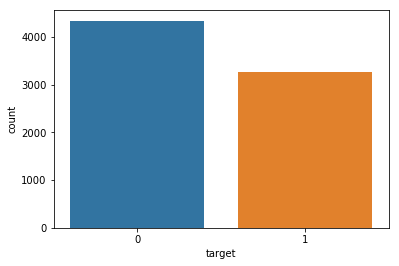

In [12]:
sns.countplot(x='target', data=train)

For location, the empty and non-empty scenarios have similar target counts.
<br>For keyword, target '1' count is almost double that of '0'. But this count is very very small and may not be useful.

In general, the count for target '0' is higher. Meaning that fake tweets are more.

---
Moving on, Let's look at the keywords column.

In [13]:
train['keyword'].unique()[:35]

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse'],
      dtype=object)

Spaces for the words have been filled with '%20'. Gotta remove them.
<br>And there are multiple values that have the same meaning. Like:
<br><span style='color:blue'>['body%20bag', 'body%20bagging', 'body%20bags']
<br>['casualties', 'casualty'], ['fatal', 'fatalities', 'fatality']</span>

<br>Stemming or lemmatization should be used. Judging by the data, stemming should be enough for this column.
<br>But I do see a case where it says:
<br><span style='color:blue'>['blew%20up', 'blown%20up']</span>
<br>Stemming can't solve this. Nevertheless, computation cost is not a concern for us here, so lemmatization can also be explored.


<br>Also, in some cases like the one shown below, two keywords have the same meaning although different words are used.
<br><span style='color:blue'>['buildings%20burning', 'buildings%20on%20fire']</span>
<br>It'll be cool to be able to identify these things.

Maybe fire-burn-blaze-ablaze can be clubbed to the same thing? A synonym analysis, if something like that is present, can help.
<br>But maybe 'fire' is often used when  it's fake and 'blaze' is used when it's real. I'll have to check if that's the case.
<br>Let's see.



In [14]:
non_numeric_keywords = set()
for keyword in train['keyword'].unique()[1:]: # First element is nan. So took [1:]
    for match in re.findall(r'[^a-zA-Z]+', keyword):
        non_numeric_keywords.add(match)

print(non_numeric_keywords)

{'%20'}


Only <span style='color:blue'>'%20'</span> seems to be the non-alphabetic value in the column. Same for test data as seen below. So we can safely replace it with a space.

In [15]:
non_numeric_keywords = set()
for keyword in test['keyword'].unique()[1:]: # First element is nan. So took [1:]
    for match in re.findall(r'[^a-zA-Z]+', keyword):
        non_numeric_keywords.add(match)

print(non_numeric_keywords)

{'%20'}


In [16]:
pattern = r'[a-zA-Z]+'
train['keyword'] = train['keyword'].apply(lambda x: ' '.join(nltk.regexp_tokenize(x, pattern)) if not pd.isnull(x) else x)
test['keyword'] = test['keyword'].apply(lambda x: ' '.join(nltk.regexp_tokenize(x, pattern)) if not pd.isnull(x) else x)

# Note that the regexp works because there's no other special characters (not even space) apart from '%20'.
# A more complex regexp would be required in other cases.

Before normalizing keyword, I'd like to test a Stemmer and a Lemmatizer from nltk and see which one suits this dataset better.
<br>I've taken a sample list to test them.

In [17]:
sample = ['building', 'bags', 'bagging', 'fatal', 'fatality', 'fatalities', 'blew', 'blown', 'blow', 'bomb', 'bombing']
wnl = nltk.WordNetLemmatizer()
[wnl.lemmatize(token) for token in sample]

['building',
 'bag',
 'bagging',
 'fatal',
 'fatality',
 'fatality',
 'blew',
 'blown',
 'blow',
 'bomb',
 'bombing']

In [18]:
porter = nltk.PorterStemmer()
[porter.stem(token) for token in sample]

['build',
 'bag',
 'bag',
 'fatal',
 'fatal',
 'fatal',
 'blew',
 'blown',
 'blow',
 'bomb',
 'bomb']

Stemmer for the win!

In [19]:
def stem_and_join(keyword):
    stemmed_keyword = [porter.stem(token) for token in keyword.split()]
    return ' '.join(stemmed_keyword)

train['trans_keyword'] = train['keyword'].apply(lambda x: stem_and_join(x) if not pd.isnull(x) else x)
test['trans_keyword'] = test['keyword'].apply(lambda x: stem_and_join(x) if not pd.isnull(x) else x)

In [20]:
train['trans_keyword'].unique()[:35]

array([nan, 'ablaz', 'accid', 'aftershock', 'airplan accid', 'ambul',
       'annihil', 'apocalyps', 'armageddon', 'armi', 'arson', 'arsonist',
       'attack', 'avalanch', 'battl', 'bioterror', 'blaze', 'bleed',
       'blew up', 'blight', 'blizzard', 'blood', 'bloodi', 'blown up',
       'bodi bag', 'bomb', 'bridg collaps', 'build burn', 'build on fire',
       'burn', 'burn build', 'bush fire', 'casualti', 'catastroph',
       'chemic emerg'], dtype=object)

In [21]:
train['trans_keyword'].fillna(' ', inplace=True)
test['trans_keyword'].fillna(' ', inplace=True)

---
That's all about keyword. Now it's time for location and text.
<br>First up: Location.

---
Let's note down the possible scenarios:
<br>1) The location names could be abbreviated / normal. Both should be treated the same.
<br>2) Some of them start with the location name followed by a comma and then there's junk. The part until comma is enough.


Hey! Instead of brainstorming about these very specific cases, I could create a frequency map and use it.
<br>See if a so-called 'unique' location has words similar to another more frequent location and equalize them.
<br>It may not be very accurate, but it'll do. I hope.

In [22]:
locationFrequencies = nltk.FreqDist(location.lower() if not pd.isnull(location) else location
                                    for location in train['location'])
locationFrequencies.most_common()

[(nan, 2533),
 ('usa', 104),
 ('new york', 75),
 ('united states', 50),
 ('london', 49),
 ('canada', 33),
 ('worldwide', 31),
 ('nigeria', 31),
 ('uk', 30),
 ('los angeles, ca', 28),
 ('india', 28),
 ('mumbai', 24),
 ('washington, dc', 21),
 ('kenya', 21),
 ('chicago, il', 19),
 ('everywhere', 19),
 ('australia', 18),
 ('california', 18),
 ('new york, ny', 16),
 ('california, usa', 15),
 ('nyc', 15),
 ('los angeles', 14),
 ('united kingdom', 14),
 ('florida', 14),
 ('washington, d.c.', 14),
 ('san francisco', 14),
 ('indonesia', 13),
 ('toronto', 13),
 ('chicago', 13),
 ('ireland', 12),
 ('texas', 12),
 ('earth', 12),
 ('world', 12),
 ('atlanta, ga', 11),
 ('san francisco, ca', 11),
 ('seattle', 11),
 ('us', 10),
 ('sacramento, ca', 10),
 ('ss', 10),
 ('london, uk', 10),
 ('london, england', 10),
 ('new york city', 10),
 ('nashville, tn', 10),
 ('304', 9),
 ('dallas, tx', 9),
 ('denver, colorado', 9),
 ('global', 9),
 ('manchester', 9),
 ('south africa', 9),
 ('san diego, ca', 9),
 ('h

In [23]:
comma_locations = []
for location in train['location']:
    if not pd.isnull(location) and len(location.split(',')) > 1:
        comma_locations.append(location)

print(len(comma_locations))

1851


Observe that in the if condition above '> 1' and '== 2' will yield almost the same result.  Meaning that most of the locations with a comma have two words in them. And most of the remaining have three.
<br>Two Words: california, usa.
<br>Three Words: alexandria, va, usa

<u>Note</u>: There could be garbage data with commas that doesn't give any usefult information. eg:- whatever, whereever, whenever.
<br>And there could be more than two words with a single comma in them. eg:- Come here, don't fear.
<br>But most of them are  genuine locations that follow our expected format. So we'll go ahead with this.

In [24]:
single_locations = []
for location in train['location']:
    if not pd.isnull(location) and len(re.findall(r'[a-zA-Z]+', location)) == 1:
        single_locations.append(location)

print(len(single_locations))

1529


These are locations with a single word and only alphabets. They're around 1529.
<br>And there are 2533 Nan values. Meaning that most of the locations belong to these three categories. That's great!

<u>Note</u>: Some locations can have a space in them, like San Francisco, so I'm splitting by commas in <i>findLocation().</i>

---
For locations with a comma, let's take the value to the extreme left.
<br>We'd be going with specific location instead of the generalized one. We'll see if that helps the model or overfits it.
<br><u>Update</u>: Taking either doesn't seem to improve the model performance that much. But! taking the generalized one reduces null values with the <i>findClosestLocation()</i> function used later on.
<br>This could be because 'text' refers to countries more than the specified locations. So now I'm taking the right extreme value.

In [25]:
def findLocation(location):
    comma_splits = location.split(',')
    splits_count = len(comma_splits)
    
    if splits_count < 1 or splits_count > 3:
        return location.lower()
    else:
        return comma_splits[splits_count-1].strip().lower()

train['trans_location'] = train['location'].apply(lambda x: findLocation(x) if not pd.isnull(x) else x)
test['trans_location'] = test['location'].apply(lambda x: findLocation(x) if not pd.isnull(x) else x)

In [26]:
comma_locations = []
for location in train['trans_location']:
    if not pd.isnull(location) and len(re.findall(r'[^a-zA-Z\s]+', location)) >= 1:
        comma_locations.append(location)

print(len(comma_locations))

976


There are some locations which have special characters. Compared to the rest, these are few.
<br>We can look for the closest match for a location and leave the rest as they are.
<br>For example:- #London -> London

<br>Also, some 'text' fields contain location information. For null fields we can make use of them.

---
For implementing this we'll make a list of frequent locations that don't have any special characters.

In [27]:
normal_location_frequencies = nltk.FreqDist( location for location in train['trans_location']
                                                    if not pd.isnull(location) and len(re.findall(r'[^a-zA-Z\s]+', location)) < 1)
                                                                        
#normal_location_frequencies.most_common()

In [28]:
normal_locations = list(normal_location_frequencies.keys())
#normal_locations

In [29]:
def findClosestLocation(record):
    matched_locations = []
    location = record['trans_location']
    text = record['text'].lower()
    if not pd.isnull(location) and len(re.findall(r'[^a-zA-Z\s]+', location)) >= 1: # for non-null loations
        for loc in re.findall(r'[a-zA-Z]+', location):
            loc = loc.lower()
            if loc in normal_locations:
                matched_locations.append(loc)
        
        if len(matched_locations) > 0:
            return max(matched_locations, key=matched_locations.count) # returns max value from the list based on count. Basically the maximum occuring location.
    
    elif pd.isnull(location) and not pd.isnull(text): # for null locations try to find location from 'text'
        for token in re.findall(r'[a-zA-Z]+', text):
            token = token.lower()
            if token in normal_locations:
                matched_locations.append(token)
        
        if len(matched_locations) > 0:
            return max(matched_locations, key=matched_locations.count)
        
    return location
        
train['transformed_location'] = train.apply(lambda x: findClosestLocation(x), axis=1)
test['transformed_location'] = test.apply(lambda x: findClosestLocation(x), axis=1)

In [30]:
comma_locations = []
for location in train['transformed_location']:
    if not pd.isnull(location) and len(re.findall(r'[^a-zA-Z\s]+', location)) >= 1:
        comma_locations.append(location)

print(len(comma_locations))
#print(comma_locations)

609


We've successfully reduced it to 609. That's really great!
<br>Looking at the locations that are left, it seems like it's mostly garbled data, most of which aren't even locations.

<u>Update</u>: I'm gonna remove these garbled locations and replace them with a space.

In [31]:
def removeGarbled(location):
    if not pd.isnull(location) and len(re.findall(r'[^a-zA-Z\s]+', location)) >= 1:
        return ''
    return location

train['transformed_location'] = train['transformed_location'].apply(lambda x: removeGarbled(x))
test['transformed_location'] = test['transformed_location'].apply(lambda x: removeGarbled(x))

In [32]:
train[train['transformed_location'].isnull()].shape

(645, 8)

The null values have reduced from 2533 to 645. That's almost 1/5th! Great!
<br>Let's fill out the rest with empty strings.

In [33]:
train['transformed_location'].fillna('', inplace=True)
test['transformed_location'].fillna('', inplace=True)

I'm pretty happy with the locations so far.

<br>Although, I could group 'USA', 'United States', 'America' etc together into one category and I could also consider two-worded locations.
<br>Update: I took a few of the most frequent locations and mapped similar ones to the same name. This still doesn't improve accuracy.

In [34]:
locationFrequencies = nltk.FreqDist(location if location in ['usa', 'us', 'u.s.a', 'u.s', 'united states', 'united states of america', 'america']
                                    else None
                                    for location in train['transformed_location'])
locationFrequencies.most_common()[1:]

[('usa', 229),
 ('united states', 59),
 ('us', 37),
 ('america', 11),
 ('united states of america', 2)]

These all mean the same thing. So let's map similar locations to a common name. 

In [35]:
location_mappings = {
    'usa': ['usa', 'us', 'u.s.a', 'u.s', 'united states', 'united states of america', 'america'],
    'ny' : ['ny', 'nyc', 'new york', 'new york city'],
    'london' : ['london', 'england', 'london uk'],
    'uk' : ['uk', 'u.k.', 'united kingdom'],
    'earth' : ['everywhere', 'earth', 'planet earth', 'worldwide', 'world', 'universe', 'planet', 'global', 'the globe']
}

mapped_keys = location_mappings.keys()

def getMappedLocations(location):
    
    for key in mapped_keys:
        if location in location_mappings.get(key):
            return key
    
    return location

train['transformed_location'] = train['transformed_location'].apply(lambda x: getMappedLocations(x))
test['transformed_location'] = test['transformed_location'].apply(lambda x: getMappedLocations(x))

Let's check now.

In [36]:
locationFrequencies = nltk.FreqDist(location if location in ['usa', 'us', 'u.s.a', 'u.s', 'united states', 'united states of america', 'america']
                                    else None
                                    for location in train['transformed_location'])
locationFrequencies.most_common()[1:]

[('usa', 338)]

Looks about right. Although, there's more we can do. (see below)
<br>Let's save that for later.

In [37]:
'''
'san antoniooooo' -> 'San Antonio'
'u.k.' -> 'uk'
'unites states' -> 'united states'
'home - syria' -> 'syria'
"'merica" -> 'america'
'''

nltk.edit_distance('us', 'united states')

11

---
Let's move on to 'text'

In [38]:
train['text'].head(10)

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
5    #RockyFire Update => California Hwy. 20 closed...
6    #flood #disaster Heavy rain causes flash flood...
7    I'm on top of the hill and I can see a fire in...
8    There's an emergency evacuation happening now ...
9    I'm afraid that the tornado is coming to our a...
Name: text, dtype: object

In [39]:
train['text'][5]

'#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires'

Here are a few things I could do:
<br>1: Replacing '#' with a space. I'm using space instead of empty string so I can get word separability in cases like '#Alaska#California'
<br>2: Removing stop words.
<br>3: Stemming / Lemmatizing
<br>4: POS tagging
<br>5: Word Vectors
<br>6: To learn about the data, I could observe the most frequently used words in real and fake cases.
<br>This'll probably help me understand if there's a linear, tree or any other complex relationship between the word frequencies and target. 

---
Let's do step 1

In [40]:
contractions = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"that'll": "that will",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are",
"you've": "you have",    
"thx"   : "thanks"
}

def removeContractions(text):
    text_tokens = text.split()
    clean_tokens = []
    
    for token in text_tokens:
        if token.lower() in contractions.keys():
            token = contractions[token.lower()]
        clean_tokens.append(token)
    
    return ' '.join(clean_tokens)

In [41]:
train['trans_text'] = train['text'].apply(removeContractions)
test['trans_text'] = test['text'].apply(removeContractions)

In [42]:
train['trans_text'].head()

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: trans_text, dtype: object

I've obtained this clean_text function from <a href="https://www.kaggle.com/latong/lstm-vs-bert-train-data-from-scratch-huggingface">this</a> notebook on Kaggle. It's not possible or expected to remember all the scenarios.
<br>Kernels and Notebooks like this help.

In [43]:
def cleanText(text):
    # To lowercase
    text = text.lower()
    # Remove hashtag while keeping hashtag text
    text = re.sub(r'#','', text)
    # Remove HTML special entities (e.g. &amp;)
    text = re.sub(r'\&\w*;', '', text)
    # Remove tickers
    text = re.sub(r'\$\w*', '', text)
    # Remove hyperlinks
    text = re.sub(r'https?:\/\/.*\/\w*', '', text)
    # Remove whitespace (including new line characters)
    text = re.sub(r'\s\s+','', text)
    text = re.sub(r'[ ]{2, }',' ',text)
    # Remove URL, RT, mention(@)
    text=  re.sub(r'http(\S)+', '',text)
    text=  re.sub(r'http ...', '',text)
    text=  re.sub(r'(RT|rt)[ ]*@[ ]*[\S]+','',text)
    text=  re.sub(r'RT[ ]?@','',text)
    text = re.sub(r'@[\S]+','',text)
    # Remove words with 2 or fewer letters
    text = re.sub(r'\b\w{1,2}\b', '', text)
    #&, < and >
    text = re.sub(r'&amp;?', 'and',text)
    text = re.sub(r'&lt;','<',text)
    text = re.sub(r'&gt;','>',text)
    # Insert space between words and punctuation marks
    text = re.sub(r'([\w\d]+)([^\w\d ]+)', '\1 \2',text)
    text = re.sub(r'([^\w\d ]+)([\w\d]+)', '\1 \2',text)
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    text= ''.join(c for c in text if c <= '\uFFFF') 
    text = text.strip()
    # Remove misspelling words
    text = ''.join(''.join(s)[:2] for _, s in itertools.groupby(text))
    # Remove punctuation
    text = ' '.join(re.sub("[\.\,\!\?\:\;\-\=\/\|\'\(\']", " ", text).split())
    # Remove emoji
    text = emoji.demojize(text)
    text = text.replace(":"," ")
    text = ' '.join(text.split()) 
    text = re.sub("([^\x00-\x7F])+"," ",text)
    # Remove Mojibake (also extra spaces)
    text = ' '.join(re.sub("[^\u4e00-\u9fa5\u0030-\u0039\u0041-\u005a\u0061-\u007a]", " ", text).split())
    return text

In [44]:
train['trans_text'] = train['trans_text'].apply(cleanText)
test['trans_text'] = test['trans_text'].apply(cleanText)

In [45]:
train['trans_text'].head()

0    our deeds are the reason this earthquake may a...
1                        forest fire near ronge canada
2    all residents asked are being notified other e...
3    people receive wildfires evacuation orders cal...
4    just got sent this photo from ruby alaska smok...
Name: trans_text, dtype: object

In [49]:
myOwnStopList=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'what','how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'do', 'should', "should", 'now', 'd', 'm', 'o', 're', 've', 'y', 'ain', "are", 'could', "was",
'would','have','get','got','getting','one','two','still','going']

def removeStopWords(text):
    text_non_stop = []
    for token in text.split():
        if token not in myOwnStopList:
            text_non_stop.append(token)
    
    return ' '.join(text_non_stop)

In [50]:
train['trans_text'] = train['trans_text'].apply(removeStopWords)
test['trans_text'] = test['trans_text'].apply(removeStopWords)

In [51]:
train['trans_text'].head()

0            deeds reason earthquake may allah forgive
1                        forest fire near ronge canada
2    residents asked notified evacuation shelter pl...
3    people receive wildfires evacuation orders cal...
4    sent photo ruby alaska smoke wildfires pours s...
Name: trans_text, dtype: object

What you consider as stop-words is subjective and problem-specific.
<br>I think it may even be model dependent. It could help Word2Vec understand context.

---

In [52]:
#special_characters = "!@#$%^&*()_+-=~`[]\;',./{}|:<>?"
stop_words = stopwords.words('english')
porter = nltk.PorterStemmer()
wnl = nltk.WordNetLemmatizer()

def tokenizeText(text):
    text_tokens = re.findall(r'[a-zA-Z]+', text)
    text_tokens = [wnl.lemmatize(token) for token in text_tokens]

    return ' '.join(text_tokens)

train['trans_text'] = train['trans_text'].apply(tokenizeText)
test['trans_text'] = test['trans_text'].apply(tokenizeText)

In [53]:
train['trans_text'][5]

'rockyfire update california closed direction due lake county fire cafire wildfire'

In [54]:
class TextSentences(object):
    """TextSentences is a generator to produce a list of tokenized sentences 
    
    Takes a list of numpy arrays containing rows of train and test data.
    
    Args:
        texts: List of texts, where each text in the list contains rows of data.
    """
    def __init__(self, *texts):
        self.texts = texts
 
    def __iter__(self):
        for text in self.texts:
            for row in text:
                for sentence in nltk.sent_tokenize(row):
                    yield nltk.word_tokenize(sentence)

def get_word2vec(sentences, location, size):
    """Returns trained word2vec
    
    Args:
        sentences: iterator for sentences
        
        location (str): Path to save/load word2vec
    """
    if exists(location):
        print('Found {}'.format(location))
        model = gensim.models.Word2Vec.load(location)
        return model
    
    print('{} not found. training model'.format(location))
    model = gensim.models.Word2Vec(sentences, size=size, window=5, min_count=5, workers=4)
    print('Model done training. Saving to disk')
    model.save(location)
    return model

Only going to use the Word2Vec model for the 'text' feature now.

In [55]:
text_w2vec = get_word2vec(
    TextSentences(
        train['trans_text'].values, 
        test['trans_text'].values
    ),
    join(real_or_not_directory, 'text_w2vmodel'), 50
)

'''
key_w2vec = get_word2vec(
    TextSentences(
        train['trans_keyword'].values, 
        #
        df_test['Text'].values  Commented for Kaggle limits
    ),
    join(real_or_not_directory, 'key_w2vmodel'), 50
)

loc_w2vec = get_word2vec(
    TextSentences(
        train['transformed_location'].values, 
        #df_test['Text'].values  Commented for Kaggle limits
    ),
    join(real_or_not_directory, 'loc_w2vmodel'), 50
)
'''

Found c:\users\avinash akella\canopy\Data\real-or-not\text_w2vmodel


"\nkey_w2vec = get_word2vec(\n    TextSentences(\n        train['trans_keyword'].values, \n        #\n        df_test['Text'].values  Commented for Kaggle limits\n    ),\n    join(real_or_not_directory, 'key_w2vmodel'), 50\n)\n\nloc_w2vec = get_word2vec(\n    TextSentences(\n        train['transformed_location'].values, \n        #df_test['Text'].values  Commented for Kaggle limits\n    ),\n    join(real_or_not_directory, 'loc_w2vmodel'), 50\n)\n"

Let's how keyword frequencies are and what we can do with them.

In [56]:
keyword_frequencies = nltk.FreqDist(keyword for keyword in train['trans_keyword'])
most_common_tuples = keyword_frequencies.most_common(60)

most_common_keywords = []

for keyword, freq  in most_common_tuples:
    most_common_keywords.append(keyword)

I observe that CountVectorizer with the most frequent words as vocabulary gives the same result as TfidVectorizer without the vocabulary.
<br>Nice.

In [57]:
keywords_vectorizer = CountVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words=None, max_features=None)    

keyword_vectors_train = keywords_vectorizer.fit_transform(train['trans_keyword'])
keyword_vectors_test = keywords_vectorizer.transform(test['trans_keyword'])

svd = TruncatedSVD(n_components=50, n_iter=50, random_state=12)
keyword_features_train = svd.fit_transform(keyword_vectors_train)
keyword_features_test = svd.transform(keyword_vectors_test)

Let's see locations

In [58]:
location_frequencies = nltk.FreqDist(location for location in train['transformed_location'])
most_common_tuples = location_frequencies.most_common(100)

most_common_locations = []

for location, freq  in most_common_tuples:
    if not location == '' or location.isspace():
        most_common_locations.append(location)

In [59]:
location_vectorizer = TfidfVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize, vocabulary=most_common_locations,
    preprocessor=None, stop_words='english', max_features=None)

location_vectors_train = location_vectorizer.fit_transform(train['transformed_location'])
location_vectors_test = location_vectorizer.transform(test['transformed_location'])

svd = TruncatedSVD(n_components=50, n_iter=50, random_state=12)
location_features_train = svd.fit_transform(location_vectors_train)
location_features_test = svd.transform(location_vectors_test)

In [60]:
class TextTokenizer:
    
    def __init__(self):
        pass
        
    def fit(self, text, y=None):
        return self
        
    def transform(self, text_rows):
        text_tokens = []
        
        for row in text_rows:
            row_tokens = []
            for sentence in nltk.sent_tokenize(row):
                row_tokens.extend(nltk.word_tokenize(sentence))
            '''
            Remove stop-words from row_tokens
            '''
            text_tokens.append(np.array(row_tokens))
        
        return np.array(text_tokens)
        
    def fit_transform(self, text_rows):
        return self.transform(text_rows)

class MeanEmbeddingVectorizer:
    
    def __init__(self, word2vec):
        self.word2vec = word2vec
        '''
        Dimension of the words vectors. This is used while calculating mean.
        For a word that doesn't have a vector we use an array of zeros that has this dimension.
        '''
        self.dim = len(word2vec.wv.syn0[0]) #len(word2vec.itervalues().next())
    
    def fit(self, X, Y=None):
        return self
    
    def transform(self, X):
        tokenized_text = TextTokenizer().fit_transform(X)
        
        return np.array([
            np.mean([self.word2vec.wv[word] for word in row if word in self.word2vec.wv]
                    or [np.zeros(self.dim)], axis=0)
            for row in tokenized_text
        ])
        
    def fit_transform(self, X, Y=None):
        return self.transform(X)

In [77]:
text_vectorizer = CountVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words=None, max_features=None)

text_vectors_train = text_vectorizer.fit_transform(train['trans_text'])
text_vectors_test = text_vectorizer.transform(test['trans_text'])

svd = TruncatedSVD(n_components=50, n_iter=50, random_state=12)
text_features_train = svd.fit_transform(text_vectors_train)
text_features_test = svd.transform(text_vectors_test)

In [62]:
text_MEV = MeanEmbeddingVectorizer(text_w2vec)
text_features_train = text_MEV.fit_transform(train['trans_text'].values)
text_features_test = text_MEV.transform(test['trans_text'].values)

c:\users\avinash akella\canopy\notebooks\practice:34: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).


I could either use a CountVectorizer or Word2Vec for text. Let's try both.

In [63]:
print(text_features_train.shape, keyword_features_train.shape, location_features_train.shape)

(7613, 50) (7613, 50) (7613, 50)


In [78]:
text_df_train = pd.DataFrame(data=text_features_train)
keyword_df_train = pd.DataFrame(data=keyword_features_train)
location_df_train = pd.DataFrame(data=location_features_train)

text_df_test = pd.DataFrame(data=text_features_test)
keyword_df_test = pd.DataFrame(data=keyword_features_test)
location_df_test = pd.DataFrame(data=location_features_test)

features_df_train = pd.concat([text_df_train], axis=1)
features_df_test = pd.concat([text_df_test], axis=1)

print(features_df_train.shape, features_df_test.shape)

(7613, 50) (3263, 50)


In [65]:
def evaluate_features(X, y, clf=None):
    """General helper function for evaluating effectiveness of passed features in ML model
    
    Prints out Log loss, accuracy, and confusion matrix with 3-fold stratified cross-validation
    
    Args:
        X (array-like): Features array. Shape (n_samples, n_features)
        
        y (array-like): Labels array. Shape (n_samples,)
        
        clf: Classifier to use. If None, default Log reg is use.
    """
    if clf is None:
        clf = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000)
    
    probas = cross_val_predict(clf, X, y, cv=StratifiedKFold(random_state=8), 
                              n_jobs=-1, method='predict_proba', verbose=2)
    pred_indices = np.argmax(probas, axis=1)
    classes = np.unique(y)
    preds = classes[pred_indices]
    print('Log loss: {}'.format(log_loss(y, probas)))
    print('Accuracy: {}'.format(accuracy_score(y, preds)))
    print('F1 Score: {}'.format(f1_score(y, preds)))
    skplt.plot_confusion_matrix(y, preds)


C:\Users\AVINASH AKELLA\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
C:\Users\AVINASH AKELLA\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


Log loss: 0.6178022466543289
Accuracy: 0.7079994745829502
F1 Score: 0.5921849201981287


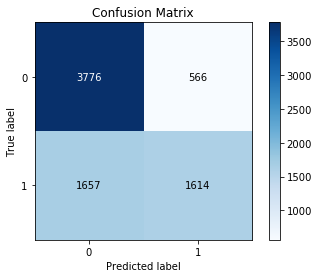

In [79]:
evaluate_features(features_df_train, train['target'])

C:\Users\AVINASH AKELLA\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.1s finished
C:\Users\AVINASH AKELLA\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


Log loss: 0.603053418496749
Accuracy: 0.7032707211349009
F1 Score: 0.6081526452732002


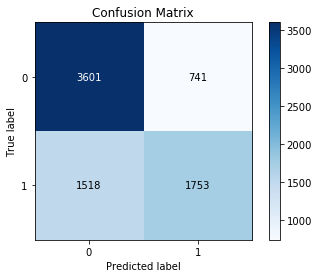

In [82]:
evaluate_features(features_df_train, train['target'], RandomForestClassifier(n_estimators=100))

In [83]:
scores = cross_val_score(RidgeClassifier(), features_df_train, train['target'], cv=3, scoring="f1")
scores[np.argmax(scores)]

0.5939323220536756

In [81]:
clf = RidgeClassifier()
clf.fit(features_df_train, train['target'])

submission = pd.read_csv(join(real_or_not_directory, "sample_submission.csv"))
submission['target'] = clf.predict(features_df_test)

The model correctly guesses fake labels, but for true labels it seems 50-50.
<br>That's equivalent to a random guess. Crap. I'll have to revisit this.
<br>Not a bad attempt for my first time doing NLP, I guess.